In [1]:
import torch

import networkx as nx

import numpy as np
    
import pandas as pd

import scipy.io

from itertools import combinations as comb

from tqdm.notebook import tqdm

import pickle

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

from numpy.linalg import pinv

In [2]:
def load_network(path):
    
    try:
        data = scipy.io.loadmat(path)
    except:
        print('Invalid data path')

    G = nx.from_scipy_sparse_array(data["Network"])
    # nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
    print(str(G))

    # convert list of lists to list
    labels = [j for i in data["Label"] for j in i]

    # Add labels to each node
    for i in range(len(G.nodes)):
        G.nodes[i]['Anomaly'] = labels[i]

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)

    return G, ego_gs, roots

# get anomalous egonets for definition 2
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [3]:
G, ego_gs, roots = load_network('datasets/blogcatalog.mat')

roots = [int(r) for r in roots]

print(f'Using {len(ego_gs)} egonets')

Graph with 5196 nodes and 172897 edges


  0%|          | 0/5196 [00:00<?, ?it/s]

Using 5196 egonets


In [4]:
# 1: anomalous egonet ==> anomalous root
# 2: anomalous egonet ==> any anomalous node

print('1: anomalous egonet ==> anomalous root')
print('2: anomalous egonet ==> any anomalous node')

anom_def = int(input('Anomalous definition: '))

anom_gs, clean_gs = [], []
if anom_def == 1:
    for idx, root_attr in enumerate(tqdm(roots)):
        if root_attr == 1:
            anom_gs.append(ego_gs[idx])
        else:
            clean_gs.append(ego_gs[idx])
elif anom_def == 2:
    for idx, g in enumerate(tqdm(ego_gs)):
        # check if root is anomolous first
        if is_anomolous(g):
            anom_gs.append(g)
        else:
            clean_gs.append(g)
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

1: anomalous egonet ==> anomalous root
2: anomalous egonet ==> any anomalous node
Anomalous definition: 2


  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 4720/5196
# of clean graphs: 476/5196


In [5]:
slice_size = int(input("Input a slice size for tensor: "))

Input a slice size for tensor: 1000


In [6]:
# cube = torch.empty((1, slice_size, slice_size, slice_size))

# for i in tqdm(range(len(clean_gs[:slice_size]))):
#     slice_gs = nx.to_numpy_array(clean_gs[i])[:slice_size, :slice_size]
#     result = np.zeros((slice_size, slice_size))
#     result[:slice_gs.shape[0],:slice_gs.shape[1]] = slice_gs
    
#     ten = torch.as_tensor(result)
#     dim = ten.shape[0]
#     cube[0, :dim, :dim, i] = ten

In [7]:
# padding adjacency matrices
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((slice_size, slice_size))
    # add 1s to diagonal
    for idx, row in enumerate(padded):
        row[idx] = 1
    if len(padded) >= len(g):
        padded[:g.shape[0], :g.shape[1]] = g
    else:
        padded = g[:slice_size, :slice_size]
    padded_anom.append(padded)
    
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((slice_size, slice_size))
    # add 1s to diagonal
    for idx, row in enumerate(padded):
        row[idx] = 1
    if len(padded) >= len(g):
        padded[:g.shape[0], :g.shape[1]] = g
    else:
        padded = g[:slice_size, :slice_size]
    padded_clean.append(padded)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

In [8]:
with open('bc_decomp_r10.sav', 'rb') as f:
    _, factors = pickle.load(f)
    f.close()

A, B, C = factors
A, B, C, = np.array(A), np.array(B), np.array(C)

results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

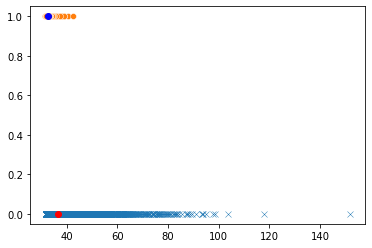

In [9]:
anom_y = np.zeros(len(anom_gs))
clean_y = np.zeros(len(clean_gs))

sns.scatterplot(x=results_anom, y=[0] * len(anom_y), marker='x')
sns.scatterplot(x=results_clean, y=[1] * len(clean_y), marker='o')
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 1, c='blue')

In [10]:
results = np.column_stack((np.array(results_clean + results_anom), np.zeros(len(ego_gs))))

In [11]:
labels = []
labels +=  [0] * len(results_clean) + [1] * len(results_anom)

# Kitchen Sink
https://pyod.readthedocs.io/en/latest/index.html

In [12]:
from pyod.models.suod import SUOD
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.anogan import AnoGAN
from pyod.models.cblof import CBLOF
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.cof import COF
from pyod.models.gmm import GMM
from pyod.models.hbos import HBOS
from pyod.models.inne import INNE
from pyod.models.copod import COPOD
from pyod.models.knn import KNN
from pyod.models.lmdd import LMDD
from pyod.models.ocsvm import OCSVM
from pyod.models.mad import MAD
from pyod.models.pca import PCA
from pyod.models.so_gaal import SO_GAAL

from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

import torch
from torch.nn import MSELoss

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(results, labels, test_size=0.33, random_state=42)

In [14]:
# DeepSVDD(), DeepSVDD(use_ae=True), AnoGAN(), AutoEncoder()
detector_list = [
    LOF(n_neighbors=20), 
    IForest(n_estimators=100), 
    GMM(), 
    KNN(), 
    HBOS(), 
    INNE(), 
    COPOD(), 
    LOF(),
]

# decide the number of parallel process, and the combination method
# then clf can be used as any outlier detection model
clf = SUOD(base_estimators=detector_list, n_jobs=2, combination='average',
           verbose=False)

In [15]:
clf.fit(X_train, y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.4s finished


SUOD(approx_clf=None, approx_clf_list=None, approx_flag_global=True,
   approx_ng_clf_list=None,
   base_estimators=[LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2), IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_st...eaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2)],
   bps_flag=True, combination='average', contamination=0.1,
   cost_forecast_loc_fit=None, cost_forecast_loc_pred=None,
   jl_method='basic', n_jobs=2, rp_clf_list=None, rp_flag_global=True,
   rp_ng_clf_list=None, target_dim_frac=0.5, verbose=False)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.




On Training Data:
SUOD ROC:0.6018, precision @ rank n:0.9157

On Test Data:
SUOD ROC:0.6382, precision @ rank n:0.9097


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished


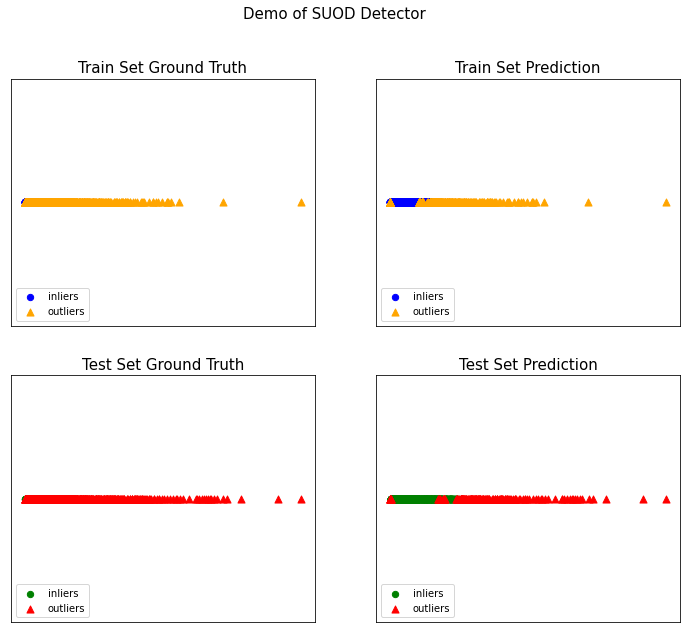

In [16]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('SUOD', y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print('SUOD', y_test, y_test_scores)

# visualize the results
visualize('SUOD', X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

In [17]:
saved_model = open('suod.sav', 'wb')
pickle.dump(clf, saved_model)
saved_model.close()